- stacked chart of player origin
- histogram of elo in a tournament
- histogram of playing time (need to transfer from string first)


In [1]:
import bga_function  #(self-made functions)
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import statistics
import datetime
import re
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas # adds hvplot method to pandas objects
from selenium.webdriver.common.action_chains import ActionChains
from contextlib import redirect_stdout
from bokeh.plotting import show
from bokeh.io import export_png
import os

# from selenium.webdriver.chrome.options import Options

waiting_time = 5

In [2]:
# service = webdriver.FirefoxService(executable_path = r'C:\Users\Simon\app\bin\geckodriver.exe')
# driver = webdriver.Firefox(service=service)
# "C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe"
service = webdriver.ChromeService(executable_path = r'C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe')
driver = webdriver.Chrome(service=service)
# # log-in  qxxxaxxx 1xxx1xxx 
driver.get("https://en.boardgamearena.com/account")
time.sleep(5)

In [3]:
clickable1 = driver.find_element(By.ID, "username_input")
ActionChains(driver)\
        .click(clickable1)\
        .send_keys("simbkt")\
        .perform()

clickable2 = driver.find_element(By.ID, "password_input")
ActionChains(driver)\
        .click(clickable2)\
        .send_keys("qwerasdf")\
        .perform()

time.sleep(3)
clickable3 = driver.find_element(By.ID, "submit_login_button")
ActionChains(driver)\
        .click(clickable3)\
        .perform()

time.sleep(waiting_time)

### Scrap tournament page: get game name, user name and link, match link


In [4]:
# get url of this tournament
tournament_link = driver.current_url

# get tournament name
tournament_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-tournament').text
print(tournament_name)

# get game name
game_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-game').find_element(By.CLASS_NAME, 'bga-link').text
print(game_name)
print(tournament_link)

# get start date
start_date = driver.find_element(By.CLASS_NAME, 'localDate').text[:10]

# get lists of names and link from the  tournament page
entries_finished_tournament = driver.find_elements(By.CLASS_NAME, 'tournaments-results-players__name')
# entries_ongoing_tournament = driver.find_elements(By.CLASS_NAME, 'tournaments-registered-players__name')
preliminary_entries = driver.find_elements(By.CLASS_NAME, 'tournaments-registered-players__player ')

entries_ongoing_tournament = []
for i in preliminary_entries:
    if i.find_element(By.CLASS_NAME, 'tournaments-registered-players__rank').text == 'invited':
        pass
    else:
        entries_ongoing_tournament.append(i.find_element(By.CLASS_NAME, 'tournaments-registered-players__name'))

# get rank of players
if game_name == '7 Wonders':
    top_rank_class = ['tournaments-results-players__player--rank1',
                      'tournaments-results-players__player--rank2',
                      'tournaments-results-players__player--rank3',
                      'tournaments-results-players__player--rank4',
                      'tournaments-results-players__player--rank5',
                      'tournaments-results-players__player--rank6',
                      'tournaments-results-players__player--rank7',
                      'tournaments-results-players__player--rank8']
else:
    top_rank_class = ['tournaments-results-players__player--rank1','tournaments-results-players__player--rank2','tournaments-results-players__player--rank3','tournaments-results-players__player--rank5']



ranked_player = []
for i in top_rank_class:
    # print(i)
    entries = driver.find_elements(By.CLASS_NAME, i)
    for _ in entries:
        result = re.findall("(.*)\n(.*)",_.text)
        link = _.find_element(By.CLASS_NAME, "playername").get_attribute('href')
        ranked_player.append([result,link])
    
players=[]
player_links=[]
tables=[]

# print results while running
for i in entries_finished_tournament + entries_ongoing_tournament:
    # print(i.text, i.get_attribute("href"))
    players.append(i.text)
    player_links.append(i.get_attribute("href"))

print("")   
print(f"number of players: {len(players)}") 
print("")
if driver.find_element(By.CLASS_NAME,'tournaments-mode-presentation__name').text !='Groups Stage':
    entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
    for i in entries_table:
        # print(i.get_attribute("href"))
        if i.text == 'Skipped': # dont include ongoing tables
            # print("skipped")
            pass
        else:
            tables.append(i.get_attribute("href"))
else: # group stage tournament 
    group_page_link = []
    for i in driver.find_elements(By.CLASS_NAME,'v2tournament__encounter-title'):
        group_page_link.append(i.get_attribute("href"))
    for link in group_page_link:
        if re.search("tournament",link): # stage 1 group link
            print("look into the page of a group...")
            driver.get(link)
            time.sleep(waiting_time)
            entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
            for i in entries_table:
                if i.text == 'Skipped': # dont include ongoing tables
                    # print("skipped")
                    pass
                else:
                    tables.append(i.get_attribute("href")) 
        else: # stage 2 elimination table links
            tables.append(link)     
            
print("")
tables_bk = tables
tables = list(filter(None, tables)) # get rid of entries of skipped tables
print("number of tables:", len(tables))

interrupt = -1


Western Pacific Ocean Cup • 3 players 1 winner - alpha
Carcassonne
https://boardgamearena.com/tournament?id=272009

number of players: 7


number of tables: 4


## Scrap user page: retrun the information of users


In [5]:
# diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    pass
else:
    pos = len(player_info) 
    print("number of iteration left: ",len(players)-pos)
    waiting_time += 1

In [6]:
# estimate script running time
scrip_player_duration = len(players) * waiting_time * 1.43    #tried 1.4 1.5 1.45 1.43 
script_player_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_player_duration)
print(f"estimate to finish scraping players at {script_player_time.strftime('%H:%M')}")

# visit every user page
if interrupt == 0: # command to start new task
    player_info = []
    for i in range(len(players)): # loop into each player's user page
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))
else: # command when interrupt
    for i in range(pos, len(players)): # when interrupt
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))

print(f"finish scraping players at {datetime.datetime.now().strftime('%H:%M')}")    

estimate to finish scraping players at 12:55
finish scraping players at 12:56


In [7]:
print("number of iteration left: ",len(players) - len(player_info) )

number of iteration left:  0


In [40]:
# extract needed information
countries = []
elos = []
languages = []
reputations = []
# read the data
for i in player_info:
    if i[0] == '':
        pass
    else:
        countries.append(i[1].split(",")[0])
        elos.append(i[2])
        languages.append(i[3])
        reputations.append(i[4])
# get Q1, Q2,Q3
elos = [int(i) for i in elos] # convert string to value  in elos
elo_q1 = int(np.quantile(elos, .25))
elo_q2 = int(np.quantile(elos, .5))
elo_q3 = int(np.quantile(elos, .75))

# get top origins of players
top_countries = (pd.DataFrame(countries).value_counts() /len(countries) *100).astype('int').astype('str') +'%'

# make plot of elo distribution
df1 = pd.DataFrame(elos, columns=['elo'])
df1['dummy'] = 1
plot = hv.BoxWhisker(df1, vdims='elo')  * df1.hvplot.scatter(y='elo' ,x = 'dummy', c='orange', size = 5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', title ='Elo of players',yaxis = None, fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width = 0
fig.toolbar.autohide = True
show(fig)
# save into png and make transparent background
elo_file = '../assets/' + game_name + tournament_name +"_Elo_" + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename = elo_file)
print('output image:', elo_file)
# time.sleep(waiting_time)
transformed_elo_file = bga_function.transparent_background(elo_file)
# os.remove(elo_file)

# list local origins
watch_list =['South Korea','North Korea','Japan',
             'China','Hong Kong','Macao','Taiwan',
             'Singapore','Viet Nam','Thailand','Indonesia','Malaysia','Philippines','Myanmar','Cambodia',
             'India','Bangladesh','Pakistan',
             'Kazakhstan','Mongolia','Georgia',
             'Australia','New Zealand','Palau']
index_list = []
index = 0
for i in countries:
    if i in watch_list:
        # print(count,i)
        index_list.append(index)
    else:
        pass
    index +=1
    
# list information
with open(game_name + ' - ' +tournament_name + '.txt', "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        print("---LocalPlayer---\n")
        for i in index_list:
            print(players[i])
        print("\n- Reputations:\n")
        for i in index_list:
            print(reputations[i])
        print("\n\n---link of user page---\n")
        for i in index_list:
            print(player_links[i])
        print("\n---Origin---\n")
        for i in index_list:
            print(countries[i])
            # print("\n")
        print("\n---Language---\n")
        for i in index_list:
            print(', '.join(languages[i]))
            # print("\n")
        print("\n\n- Origins of players:\n")
        print(top_countries)
        print("\n\n\n- Q1/Q2/Q3 of player's Elo rating:\n")
        print(f"{elo_q1}/{elo_q2}/{elo_q3}")
f.close()
# print("---LocalPlayer---\n")
# for i in index_list:
#     print(players[i])
# print("\n- Reputations:\n")
# for i in index_list:
#     print(reputations[i])
# print("\n\n---link of user page---\n")
# for i in index_list:
#     print(player_links[i])
# print("\n---Origin---\n")
# for i in index_list:
#     print(countries[i])
#     # print("\n")
# print("\n---Language---\n")
# for i in index_list:
#     print(', '.join(languages[i]))
#     # print("\n")
# print("\n\n- Origins of players:\n")
# print(top_countries)
# print("\n\n\n- Q1/Q2/Q3 of player's Elo rating:\n")
# print(f"{elo_q1}/{elo_q2}/{elo_q3}")


### finish scraping player data
time.sleep(waiting_time)
interrupt = -1


output image: ../assets/CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812131004.png
output image: ../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812131004.png


## list of tables, return table duration and slow players:

In [12]:
### diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    pass
else:
    pos = len(table_info) 
    print("number of iteration left: ",len(tables)-pos)
    waiting_time += 1


# interrupt = 1
# pos = len(table_info)
# print(pos-1, table_info[-1], "\n")
# print("number of iteration left: ",len(tables))
# for x in range(pos-2, len(tables)):
#   print(x, tables[x])



In [13]:
# loop into all tables

# estimate time
# waiting_time = 15
scrip_table_duration = len(tables) * waiting_time * 1.5
script_table_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_table_duration)
print(f"estimate to finish scraping tables at {script_table_time.strftime('%H:%M')}")

# >>>>> when scraping for the first time
if interrupt == 0:
    table_info = []
    for i in range(len(tables)):
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))
else: 
# >>>>> when interrupt
    for i in range(pos, len(tables)): 
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))


estimate to finish scraping tables at 13:02


In [14]:
print("number of iteration left: ",len(tables)-len(table_info))


number of iteration left:  0


In [15]:
# list players that is either too slow or leave the game intentionly
black_list = []
for i in table_info:
    if i[3] != '': # leave or kicked
        black_list.append(i[3]) 
    elif i[4] != '':  # didnt finish on time
        black_list.append(i[4]) 
    
    
# append the black list to the file
f = open(game_name + ' - ' +tournament_name + '.txt', "a", encoding='utf-8')
f.write("\n---BlackList---\n\n") 
for i in black_list:
    f.write(i)
    f.write("\n")
f.close()

In [16]:
# statistics"""'
number_tables = len(tables)
ratio_cancelled_tables = 0
for i in range(len(table_info)):
    # print(table_info[i][0])
    ratio_cancelled_tables += 1/number_tables if table_info[i][0] == 'cancelled' else 0

ratio_abandoned_tables = 0
for i in range(len(table_info)):
    ratio_abandoned_tables +=1/number_tables if table_info[i][0] == 'abandoned' else 0    
    
table_times = []
for i in range(len(table_info)):
    table_times.append(table_info[i][1])

# create df with player name and time spent
df = pd.DataFrame(columns = ['Player', 'Used_time'])
for i in range(len(table_info)):
    players_time = table_info[i][2] 
    for i in players_time:
        dict = {'Player':[i[0]], 
                'Used_time':[i[1]] 
               } 
        df_add = pd.DataFrame(dict) 
        df = pd.concat([df, df_add], ignore_index = True) 


# convert the unit of duration into days
converted_table_times = bga_function.time_converstion(table_times)

# spread statistics
median_duration = round(statistics.median(converted_table_times),1)
duration_q1 = (np.quantile(converted_table_times, .25))
duration_q2 = (np.quantile(converted_table_times, .5))
duration_q3 = (np.quantile(converted_table_times, .75))
print("Q1/Q2/Q3 quantile: ", duration_q1,duration_q2,duration_q3)


Q1/Q2/Q3 quantile:  0.25 1.2000000000000002 3.325


In [17]:
# plot
from bokeh.plotting import show
from bokeh.io import export_png

df2 = pd.DataFrame(converted_table_times, columns=['tt'])
df2['dummy'] = 1
plot = hv.BoxWhisker(df2, vdims='tt')  * df2.hvplot.scatter(y='tt' ,x = 'dummy', c='orange', size=5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', yaxis=None, title='Table duration (days)',fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width =0
fig.toolbar.autohide = True
show(fig)

# save into png and make transparent background
duration_file = '../assets/'+ game_name + tournament_name + "_Duration_" +time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename=duration_file)
print('output image:', duration_file)
transformed_duration_file = bga_function.transparent_background(duration_file)
os.remove(duration_file)



output image: ../assets/CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Duration_20240812130206.png
output image: ../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Duration_20240812130206.png


In [18]:
### finish table part
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
time.sleep(waiting_time)

- Abandoned tables (reached duration limit): 25%
- Cancelled tables (player left or got kicked): 0%


## summary

In [19]:
# summary message
print(f"- [{tournament_name.replace("Western Pacific Ocean Cup • ","")}]({tournament_link})")
print("- Date:",start_date, "- __/__/2024") #put this manually 
print('- Number of players:', len(players))
print("- Top origins of players:",top_countries.index[0][0], f"{top_countries.iloc[0]}", top_countries.index[1][0], f"{top_countries.iloc[1]}", top_countries.index[2][0], f"{top_countries.iloc[2]}", top_countries.index[3][0], f"{top_countries.iloc[3]}", top_countries.index[4][0], f"{top_countries.iloc[4]}") 
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
print("- Q1/Q2/Q3 of player's Elo rating:", f"{elo_q1}/{elo_q2}/{elo_q3}")
print("- Q1/Q2/Q3 of table duration (days):", f"{round(duration_q1,1)}/{round(duration_q2,1)}/{round(duration_q3,1)}") #put this later 
# print('- Winners:', f"\U0001F947{players[0]}", f"\U0001F948{players[1]}", f"\U0001F949{players[2]}")
print("- Winners(meta event points):", 
    f'{ranked_player[0][0][0][0]}(100);', 
    f'{ranked_player[1][0][0][0]}(75);',
    f'{ranked_player[2][0][0][0]}(50);',
    f'{ranked_player[3][0][0][0]}(50);',
    f'{ranked_player[4][0][0][0]}(10);',    
    f'{ranked_player[5][0][0][0]}(10);',
    f'{ranked_player[6][0][0][0]}(10);',
    f'{ranked_player[7][0][0][0]}(10)',)

# image links
print("")
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/(.*)',transformed_elo_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px; margin-top:-15px"/>', sep='')
print('</div>')
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/(.*)',transformed_duration_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px;"/>', sep='')
print('</div>')
# print("")
print('<p>&nbsp;</p>')


# Things to check manually
print("\n\n1. check last day of tournament from the tournament page")
print("2. change the 4th player point to 25")




- [3 players 1 winner - alpha](https://boardgamearena.com/tournament?id=272009)
- Date: 02/12/2024 - __/__/2024
- Number of players: 7
- Top origins of players: Taiwan 28% Belarus 14% Belgium 14% France 14% Russia 14%
- Abandoned tables (reached duration limit): 25%
- Cancelled tables (player left or got kicked): 0%
- Q1/Q2/Q3 of player's Elo rating: 199/234/404
- Q1/Q2/Q3 of table duration (days): 0.2/1.2/3.3


IndexError: list index out of range

# Player_ranking

In [22]:
# add region information to ranked players
for item in ranked_player:
    player_region = bga_function.get_player_info(driver, waiting_time, item[1], game_name)[1]
    item.append(player_region)
    

In [23]:
print("2. paste information below to csv:")
print(">>\n")
for item in ranked_player:
    print(game_name,",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",",item[0][0][1], sep='')    
# for item in ranked_player:
#     print("All Games",",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",", item[0][0][1], sep='')


2. paste information below to csv:
>>

Azul,Season 2,Kndr,China,1st
Azul,Season 2,nya11,Japan,2nd
Azul,Season 2,Hyperion7,France,3rd
Azul,Season 2,oldteajar,Australia,3rd
Azul,Season 2,Lwenyuan,China,5th
Azul,Season 2,amybomb,Australia,5th
Azul,Season 2,simtt,Thailand,5th
Azul,Season 2,loladub2,France,5th
All Games,Season 2,Kndr,China,1st
All Games,Season 2,nya11,Japan,2nd
All Games,Season 2,Hyperion7,France,3rd
All Games,Season 2,oldteajar,Australia,3rd
All Games,Season 2,Lwenyuan,China,5th
All Games,Season 2,amybomb,Australia,5th
All Games,Season 2,simtt,Thailand,5th
All Games,Season 2,loladub2,France,5th


In [ ]:
# after update the csv file, output the graph

for GameName in ['7 Wonders','Splendor', 'Wingspan', 'Kingdomino','Carcassonne', 'Azul','All Games']:
    # bga_function.PlayerRankingChart(GameName)
    bga_function.PlayerRankingChart(GameName)

    time.sleep(waiting_time)

### possible new features


In [49]:
    game_data = data[data['game'] == GameName].sort_values(by='point', ascending=True)
    acc_game_data = game_data.groupby('player')['point'].sum().sort_values(ascending=False)

In [51]:
game_data

,game,edition,player,country,point
143,All Games,Season 2,Didzou,France,10
46,All Games,Season 1,scarxo,Australia,10
47,All Games,Season 1,nya11,Japan,10
110,All Games,Season 2,craig_shoji,Japan,10
109,All Games,Season 2,Random_23,Ukraine,10
...,...,...,...,...,...
24,All Games,Season 1,cieciel,Poland,100
104,All Games,Season 2,Lichidakiller,Mexico,100
88,All Games,Season 1,Zenphy,Belgium,100
120,All Games,Season 2,kiki1234555,Hong Kong,100


In [3]:
def PlayerRankingChart(GameName):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Setup data
    data = pd.read_csv('../assets/csv/result.csv')     
    game_data = data[data['game'] == GameName].sort_values(by='point', ascending=True)
    acc_game_data = game_data.groupby('player')['point'].sum().sort_values(ascending=False)
    selected_data = pd.DataFrame({'player':acc_game_data.index, 'point':acc_game_data.values})    
    selected_data["player.Upper"] = selected_data["player"].str.upper()
    selected_data = selected_data.sort_values(['point', 'player.Upper'], ascending=[True,False])
    
    
    
    # Setup plot size.
    # fig, ax = plt.subplots()
    vertical_size = len(selected_data) / 3.5
    fig, ax = plt.subplots(figsize=(5,vertical_size))
    

    # Create grid
    # Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
    ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)

    # Remove splines. Can be done one at a time or can slice with a list.
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)
    ax.margins(y=0)


    # Plot data
    ax.barh(selected_data['player'], selected_data['point'], color='#006BA2', zorder=2)

    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                             labelbottom=False,  # Set no x-axis labels on bottom
                             bottom=False,       # Set no ticks on bottom
                             labelsize=11,       # Set tick label size
                             pad=-1)             # Lower tick labels a bit

    # Reformat y-axis tick labels
    ax.set_yticklabels(selected_data['player'],      # Set labels again
                       ha = 'left')              # Set horizontal alignment to left
    ax.yaxis.set_tick_params(pad=100,            # Pad tick labels so they don't go over y-axis
                             labelsize=9,       # Set label size
                             bottom=False)       # Set no ticks on bottom/left

    # Add in title and subtitle
    FigName = GameName.replace(" ","") + 'Ranking.png'
    plt.savefig(FigName, transparent=True, bbox_inches='tight')
    
    top_country = game_data.groupby('country')['point'].sum().sort_values(ascending=False)
    print(GameName," Region ranking: ", end='')
    print(f'🥇{top_country.index[0]}({top_country.iloc[0]}) 🥈{top_country.index[1]}({top_country.iloc[1]}) 🥉{top_country.index[2]}({top_country.iloc[2]})')
    print(top_country.head())

    return None

C:\Users\Simon\AppData\Local\Temp\ipykernel_10832\4043380068.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['player'],      # Set labels again


Wingspan  Region ranking: 🥇United States of America(160) 🥈Australia(100) 🥉Hong Kong(100)
country
United States of America    160
Australia                   100
Hong Kong                   100
Peru                         60
France                       50
Name: point, dtype: int64


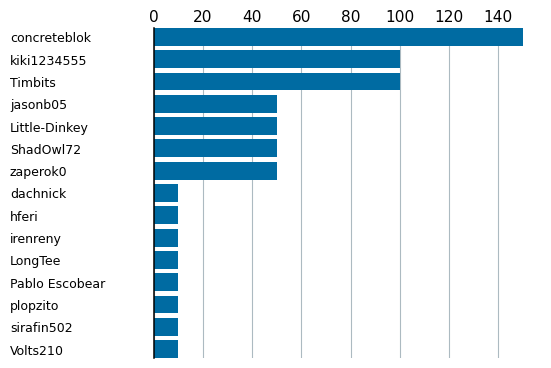

In [71]:
PlayerRankingChart('Wingspan')

C:\Users\Simon\AppData\Local\Temp\ipykernel_10468\1926009357.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['player'],      # Set labels again


All Games  Region ranking: 🥇Japan(280) 🥈Philippines(275) 🥉United States of America(235)
country
Japan                       280
Philippines                 275
United States of America    235
China                       215
Belgium                     160
Name: point, dtype: int64


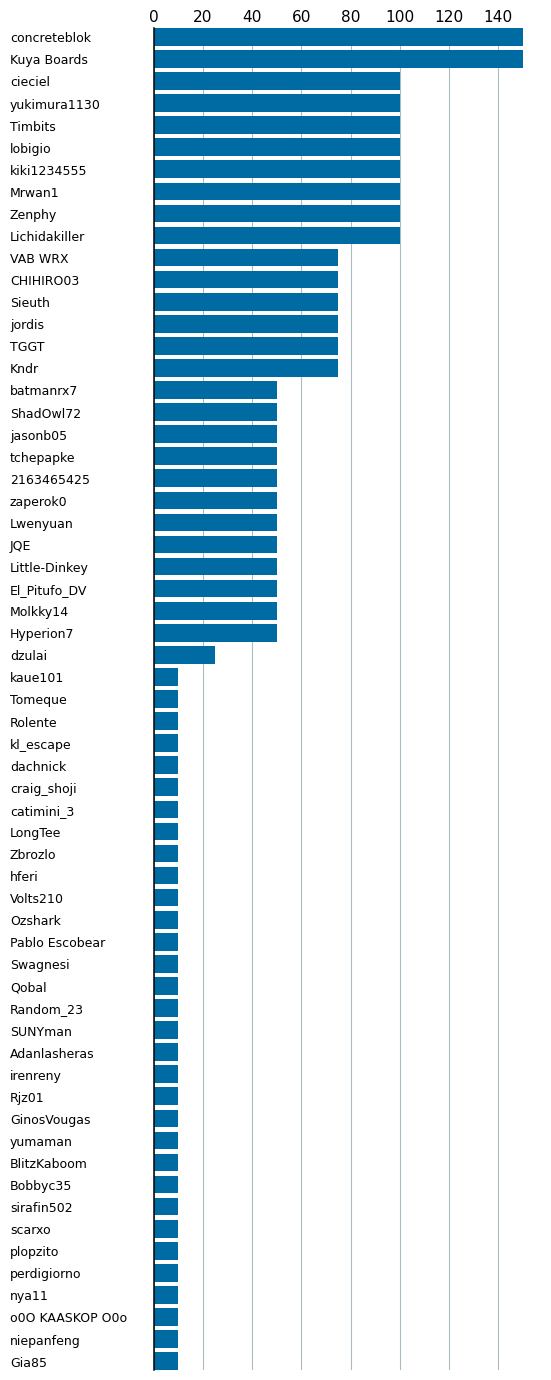

In [34]:
PlayerRankingChart('All Games')

In [24]:
new_image_file = '../assets/t_' + re.findall("assets/(.*)",elo_file)[0]
'../assets/t_' + re.findall("assets/(.*)",elo_file)[0]

'../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

In [22]:
elo_file

'../assets/CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

In [26]:
re.findall("(.*)assets/(.*)",elo_file)

[('../',
  'CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png')]

In [31]:
re.findall("(.*assets)/(.*)",elo_file)[0][0]

'../assets'

In [30]:
re.findall("(.*assets)/(.*)",elo_file)[0][1]

'CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

In [35]:
re.findall("(.*assets)/(.*)",elo_file)[0][0] + \
'/t_' + \
re.findall("(.*assets)/(.*)",elo_file)[0][1]

'../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

In [36]:
'../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

'../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812130434.png'

In [37]:
def transparent_background(image_file):
    from PIL import Image
    img = Image.open(image_file)
    rgba = img.convert('RGBA')
    datas = rgba.getdata()

    newData = []

    for item in datas:

       if item[0] == 255 and item[1] == 255 and item[2] == 255:
           newData.append((255, 255, 255, 0))
       else:
          newData.append(item)
    rgba.putdata(newData)
    
    # new_image_file = 't_' + image_file  
    # new_image_file = '../assets/t_' + re.findall("assets/(.*)",image_file)[0]
    new_image_file = re.findall("(.*assets)/(.*)",elo_file)[0][0] + \
    '/t_' + \
    re.findall("(.*assets)/(.*)",elo_file)[0][1]
    
    rgba.save(new_image_file, 'PNG')
    print('output image:', new_image_file)
    return new_image_file



In [42]:
transparent_background(elo_file)

output image: ../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812131004.png


'../assets/t_CarcassonneWestern Pacific Ocean Cup • 3 players 1 winner - alpha_Elo_20240812131004.png'